# Imports

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sys.path.insert(1, '/kaggle/input/credit')
# from util import *
from Config.util import *

In [3]:
pd.set_option('display.max_columns', None)

# Dataset

In [4]:
data = pd.read_csv('Datasets/Credit/credit.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [5]:
target_col_name = 'Credit amount'

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [7]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [8]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [9]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               522 non-null    int64 
 1   Sex               522 non-null    object
 2   Job               522 non-null    int64 
 3   Housing           522 non-null    object
 4   Saving accounts   522 non-null    object
 5   Checking account  522 non-null    object
 6   Credit amount     522 non-null    int64 
 7   Duration          522 non-null    int64 
 8   Purpose           522 non-null    object
dtypes: int64(4), object(5)
memory usage: 36.8+ KB


In [10]:
object_cols = data.select_dtypes(include='object').columns.to_list()
object_cols.append('Job')
data[object_cols] = data[object_cols].astype(str)
for col in object_cols:
    print(f"{col} is{'' if is_consumption(data, col, target_col_name, 0.5) else ' not'} a consumption column")

Sex is not a consumption column
Housing is not a consumption column
Saving accounts is not a consumption column
Checking account is not a consumption column
Purpose is not a consumption column
Job is not a consumption column


In [11]:
data = pd.get_dummies(data, columns=object_cols)
data.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3
0,22,5951,48,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
1,45,7882,42,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
2,53,4870,24,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False
3,35,6948,36,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True
4,28,5234,30,False,True,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True


In [12]:
data = standardize_features(data, target_col_name)

# PCA

In [13]:
pca_result = PCA(n_components=1).fit_transform(data.drop(columns=[target_col_name]))
data['PCA'] = pca_result[:, 0]

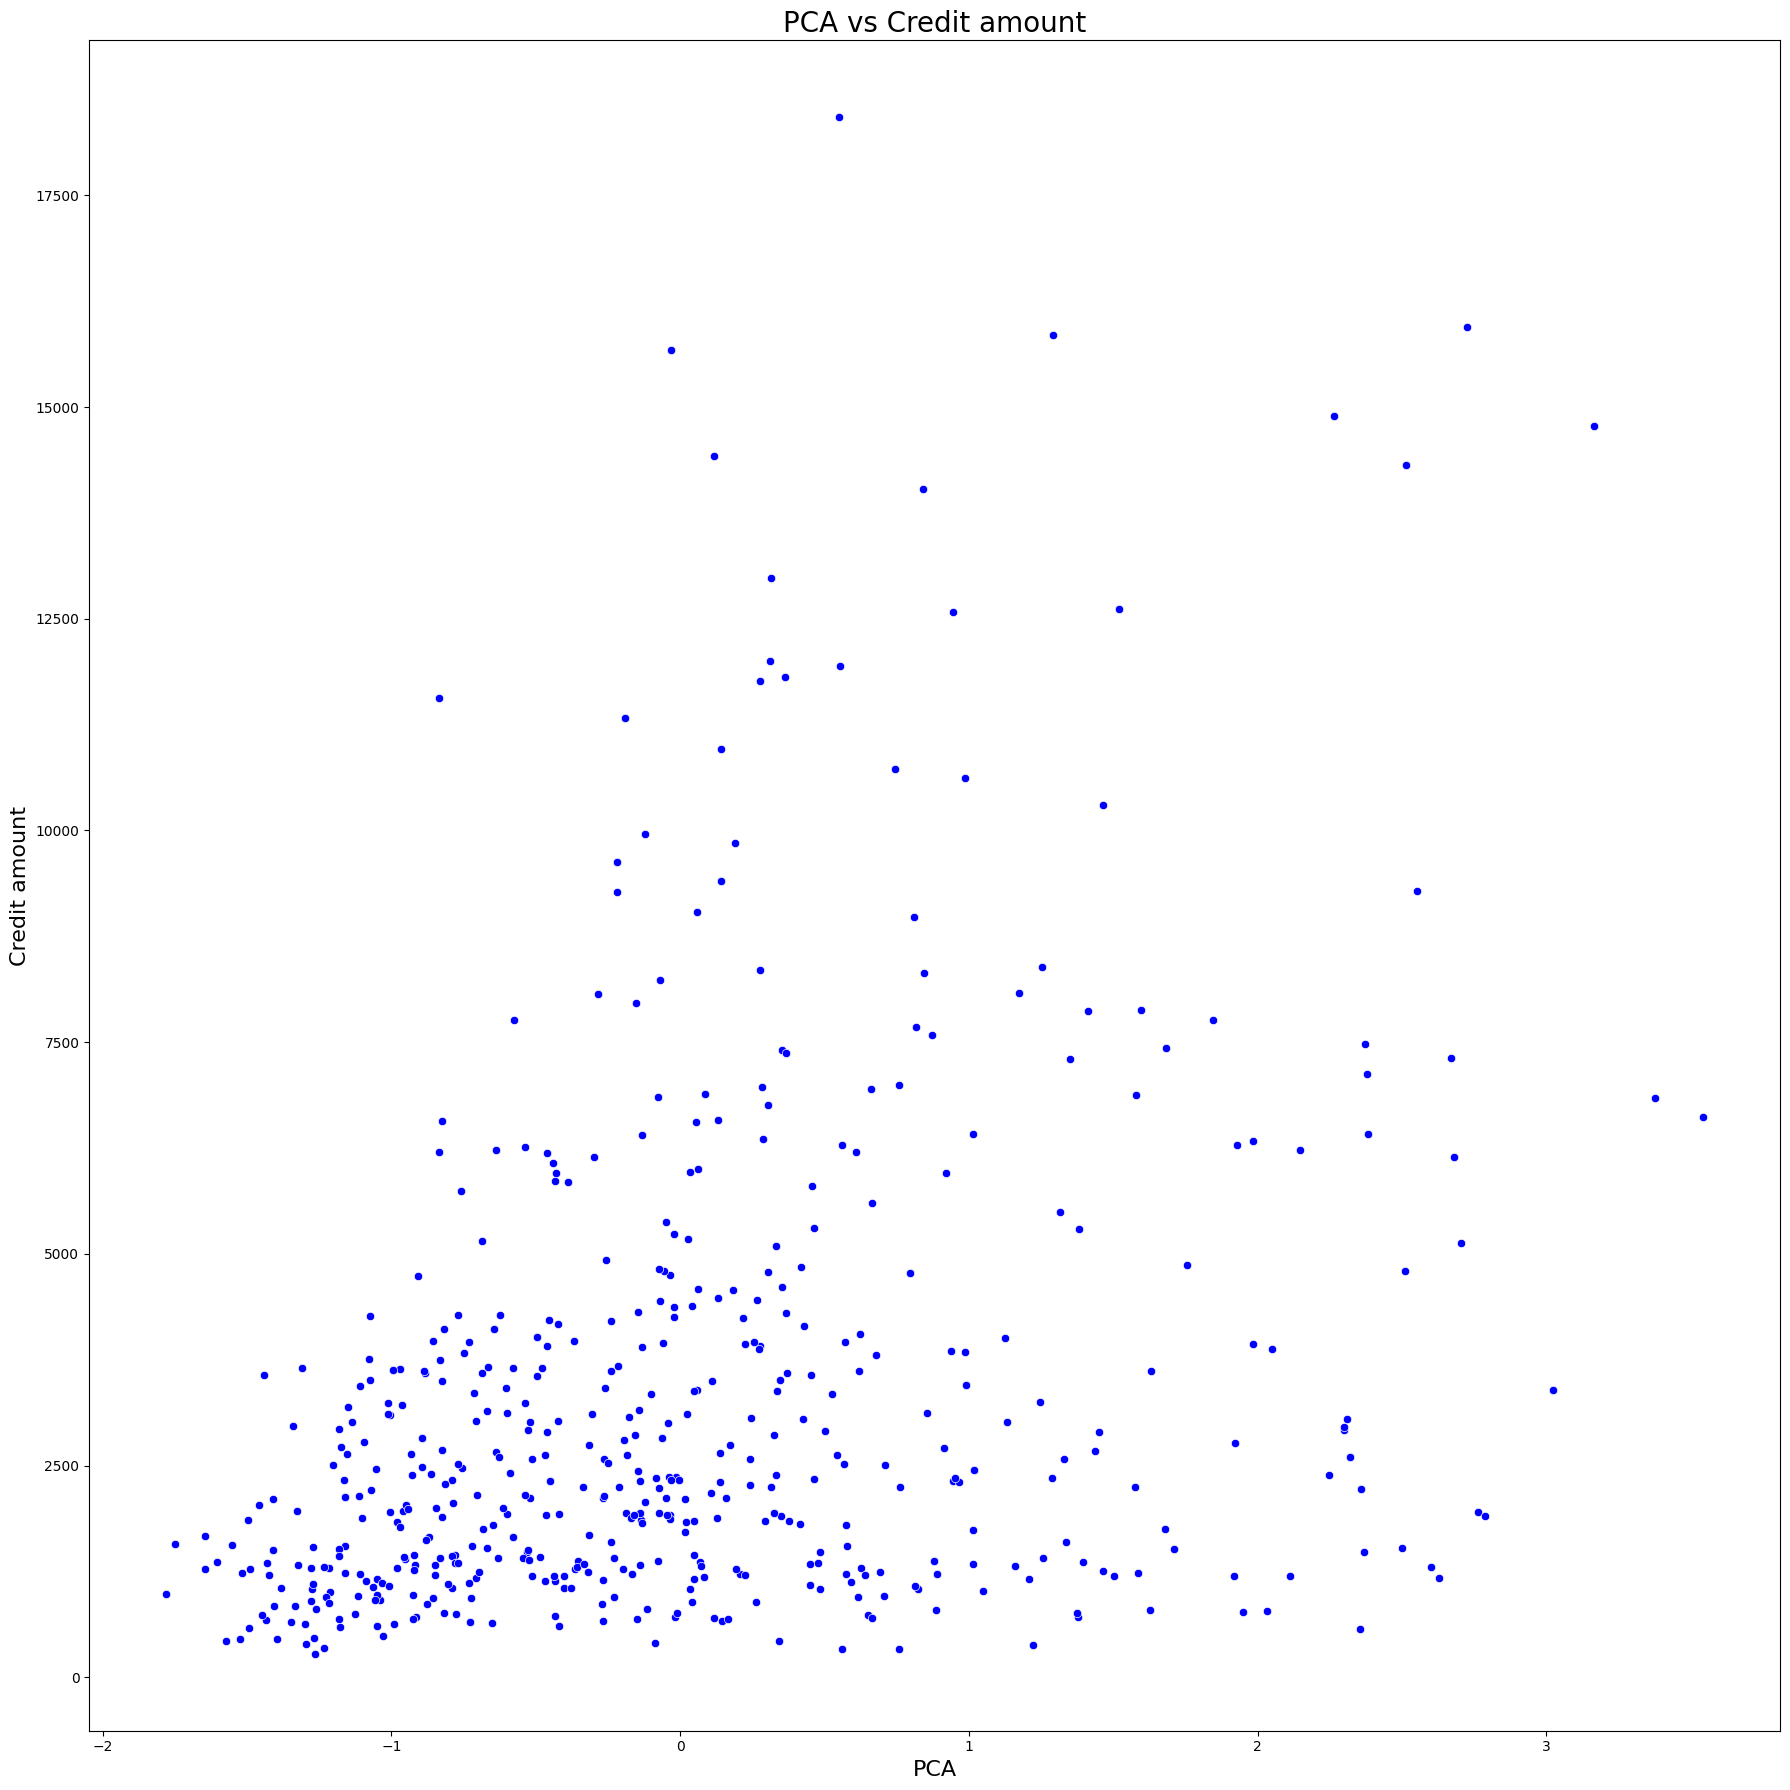

In [14]:
fig, axe = plt.subplots(figsize=(18, 18))

sns.scatterplot(x='PCA', y=target_col_name, data=data, ax=axe, color='b')
axe.set_title(f'PCA vs {target_col_name}', fontsize=20)
axe.set_xlabel('PCA', fontsize=16)
axe.set_ylabel(target_col_name, fontsize=16)

plt.tight_layout()
plt.show()

# Training

In [15]:
test_pairs = generate_random_pairs(data, 20000)
test_df = create_pair_df(data, test_pairs, target_col_name)

In [16]:
tree_depth = int(np.round(np.sqrt(len(data.columns))))

In [17]:
mf1 = train_evaluate_repeat(generate_random_pairs, data, num_samples=100000, depth=tree_depth, test_df=test_df, use_bradley=True, add_noise=False, exp=False, noise=0.1, label_col=target_col_name, repeats=1)

100%|██████████| 1/1 [00:30<00:00, 30.21s/it]

Mean Accuracy: 0.87375
Mean Precision: 0.8734164588528678
Mean Recall: 0.8745505393527767
Mean F1 Score: 0.8739831312072666


In [18]:
var, residuals = calculate_pca_var(data, target_col_name)
print(var)

24.010213741809476


In [19]:
# Calculating the number of pairs
max_pairs = len(data) * 10
alpha = 1e-7

num_pairs = int(max_pairs / (1 + alpha * var))
print(num_pairs)

5219


In [20]:
pretrain_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': tree_depth
}
pretrained_model = pretrain_model_with_residuals(df=data, n_samples=num_pairs, pretrain_params=pretrain_params, target_col=target_col_name, residuals=residuals)

Large number of repeats to avoid noise

In [21]:
step = 50
num_samples = 800
repeats = 40

f1_scores_UB_repeats = []
f1_scores_UP_repeats = []
f1_scores_RB_repeats = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats.append(f1_scores_UB)
    f1_scores_UP_repeats.append(f1_scores_UP)
    f1_scores_RB_repeats.append(f1_scores_RB)

save_f1_scores("Plots/credit_f1_repeat.pkl", f1_scores_UB_repeats, f1_scores_UP_repeats, f1_scores_RB_repeats)
# Compute the average F1 scores across repeats
average_f1_scores_UB = np.mean(f1_scores_UB_repeats, axis=0)
average_f1_scores_UP = np.mean(f1_scores_UP_repeats, axis=0)
average_f1_scores_RB = np.mean(f1_scores_RB_repeats, axis=0)

Blank model with random pairs: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


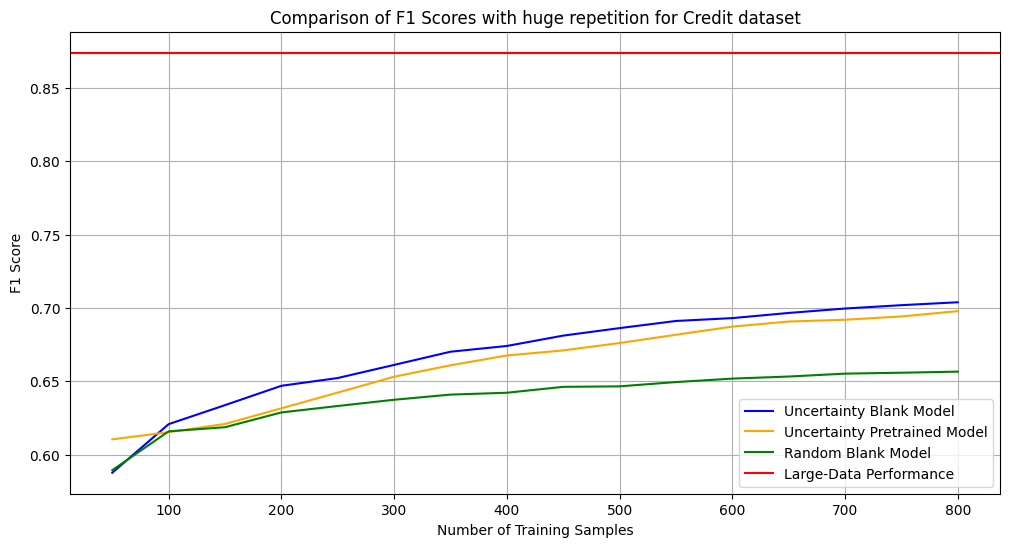

In [22]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Large-Data Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with huge repetition for Credit dataset')
plt.legend()
plt.grid(True)
plt.show()

Wide spectrum of values to capture the trend

In [23]:
step = 50
num_samples = 10000
repeats = 1

f1_scores_UB_repeats2 = []
f1_scores_UP_repeats2 = []
f1_scores_RB_repeats2 = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats2.append(f1_scores_UB)
    f1_scores_UP_repeats2.append(f1_scores_UP)
    f1_scores_RB_repeats2.append(f1_scores_RB)

save_f1_scores("Plots/credit_f1_wide.pkl", f1_scores_UB_repeats2, f1_scores_UP_repeats2, f1_scores_RB_repeats2)
# Compute the average F1 scores across repeats
average_f1_scores_UB2 = np.mean(f1_scores_UB_repeats2, axis=0)
average_f1_scores_UP2 = np.mean(f1_scores_UP_repeats2, axis=0)
average_f1_scores_RB2 = np.mean(f1_scores_RB_repeats2, axis=0)

Blank model with random pairs: 100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


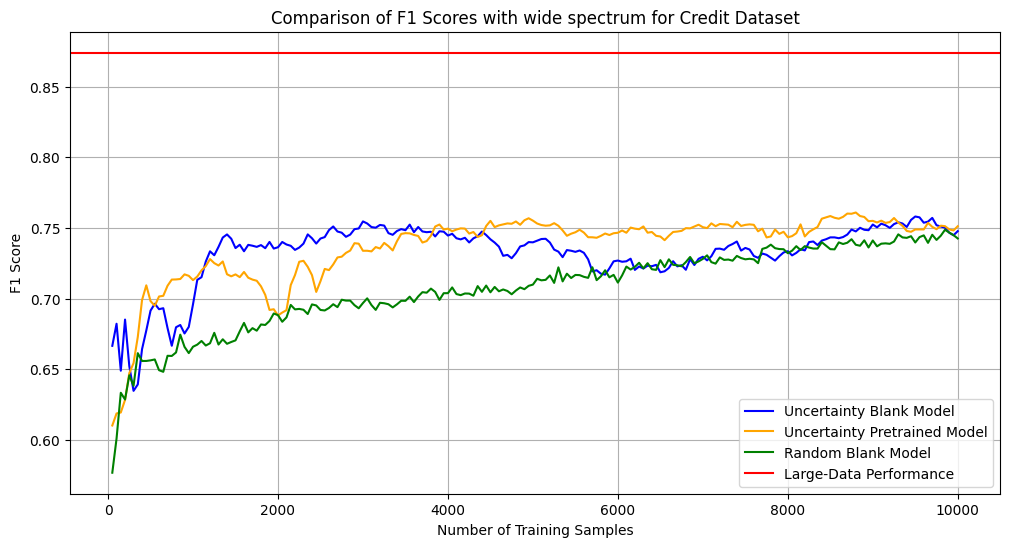

In [24]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB2, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP2, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB2, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Large-Data Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with wide spectrum for Credit Dataset')
plt.legend()
plt.grid(True)
plt.show()